This notebook demonstrates how to optimize the hyperparameters of an `XGBRegressor` with GPyOpt and how Bayesian optimization performance compares to random search. `XGBRegressor` is part of [XGBoost](https://xgboost.readthedocs.io/), a flexible and scalable gradient boosting library. `XGBRegressor` implements the scikit-learn estimator API and can be applied to regression problems. Regression is performed on a small [toy dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes) that is part of scikit-learn.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from GPyOpt.methods import BayesianOptimization
from scipy.stats import uniform
from xgboost import XGBRegressor
%matplotlib inline


In [3]:
# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

/Users/pradeepsingh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


### Hyperparameter tuning with random search

For hyperparameter tuning with random search, we use `RandomSearchCV` of scikit-learn and compute a cross-validation score for each randomly selected point in hyperparameter space. Results will be discussed below.

In [4]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);

/Users/pradeepsingh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/pradeepsingh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Hyperparameter tuning with Bayesian optimization

To tune hyperparameters with Bayesian optimization we implement an objective function `cv_score` that takes hyperparameters as input and returns a cross-validation score. Here, we assume that cross-validation at a given point in hyperparameter space is deterministic and therefore set the `exact_feval` parameter of `BayesianOptimization` to `True`. Depending on model fitting and cross-validation details this might not be the case but we ignore that here.

In [5]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

In [6]:
# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [11]:
optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

In [14]:
# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

### Results

On average, Bayesian optimization finds a better optimium in a smaller number of steps than random search and beats the baseline in almost every run. This trend becomes even more prominent in higher-dimensional search spaces. Here, the search space is 5-dimensional which is rather low to substantially profit from Bayesian optimization. One advantage of random search is that it is trivial to parallelize. Parallelization of Bayesian optimization is much harder and subject to research (see \[4\], for example).

Baseline neg. MSE = -3498.95
Random search neg. MSE = -3633.23
Bayesian optimization neg. MSE = -3115.00


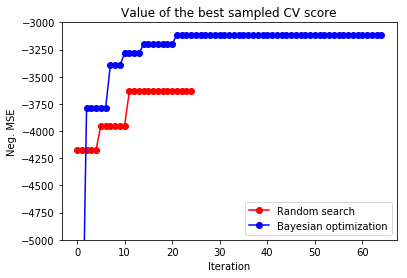

In [21]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();